### Capstone 1: White Wine Quality, UC Irvine
(Source: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009)

# 6a. Random Forest Regressor
## White Wine, Outliers Removed

#### Audrey Hughes Rager
#### December 30, 2020


In [2]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

sns.set_style('whitegrid')

## Data Wrangling

### Import Data

In [3]:
#Import csv files into Pandas data frames
df = pd.read_csv('winequality-white.csv',sep=";")
df = df.rename({'fixed acidity': 'fixed_acidity','volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'residual sugar':'residual_sugar',  'free sulfur dioxide':'free_sulfur_dioxide', 'total sulfur dioxide':'total_sulfur_dioxide'}, axis=1)



### Remove Outliers

In [4]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
ValueList = ('fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
            'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol')

for myValue in ValueList:
    #compute range of data
    myValueMax = df[myValue].max()
    myValueMin = df[myValue].min()
    myValueRange = myValueMax - myValueMin
    
    # Computing IQR
    Q1 = df[myValue].quantile(0.25)
    Q3 = df[myValue].quantile(0.75)
    IQR = Q3 - Q1
    gtdropvalue = (Q3 + (1.5 * IQR))
    ltdropvalue = (Q1 - (1.5 * IQR))
    
    index_names_right = df[df[myValue] >= gtdropvalue].index
    index_names_left = df[df[myValue] <= ltdropvalue].index
    df.drop(index_names_right, inplace = True)
    df.drop(index_names_left, inplace = True)
    print(myValue + ' maximum: ' + str(myValueMax))
    print(myValue + ' minimum: ' + str(myValueMin))
    print(myValue + ' Q1: ' + str(Q1))
    print(myValue + ' Q3: ' + str(Q3))
    print(myValue + ' range: ' + str(myValueRange))
    print(myValue + ' IQR: ' + str(IQR))
    print('ratio of Range fo IQR: ' + str(myValueRange/IQR))
    print()
    
   

fixed_acidity maximum: 14.2
fixed_acidity minimum: 3.8
fixed_acidity Q1: 6.3
fixed_acidity Q3: 7.3
fixed_acidity range: 10.399999999999999
fixed_acidity IQR: 1.0
ratio of Range fo IQR: 10.399999999999999

volatile_acidity maximum: 1.1
volatile_acidity minimum: 0.08
volatile_acidity Q1: 0.21
volatile_acidity Q3: 0.32
volatile_acidity range: 1.02
volatile_acidity IQR: 0.11000000000000001
ratio of Range fo IQR: 9.272727272727272

citric_acid maximum: 1.66
citric_acid minimum: 0.0
citric_acid Q1: 0.27
citric_acid Q3: 0.38
citric_acid range: 1.66
citric_acid IQR: 0.10999999999999999
ratio of Range fo IQR: 15.090909090909092

residual_sugar maximum: 31.6
residual_sugar minimum: 0.6
residual_sugar Q1: 1.8
residual_sugar Q3: 9.6
residual_sugar range: 31.0
residual_sugar IQR: 7.8
ratio of Range fo IQR: 3.9743589743589745

chlorides maximum: 0.34600000000000003
chlorides minimum: 0.012
chlorides Q1: 0.036000000000000004
chlorides Q3: 0.05
chlorides range: 0.334
chlorides IQR: 0.01399999999999999

### EDA


In [5]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000
mean,6.809048,0.263828,0.322749,6.352759,0.042299,34.730575,136.953176,0.993844,3.189043,0.481445,10.592035,5.953936
std,0.726417,0.076298,0.083076,4.905477,0.009889,14.941739,41.049024,0.002877,0.137980,0.098904,1.214421,0.856194
min,4.900000,0.080000,0.110000,0.600000,0.016000,2.000000,19.000000,0.987110,2.830000,0.220000,8.400000,3.000000
25%,6.300000,0.210000,0.270000,1.800000,0.035000,24.000000,107.000000,0.991580,3.100000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.310000,5.200000,0.042000,34.000000,132.000000,0.993520,3.180000,0.470000,10.500000,6.000000
75%,7.300000,0.310000,0.370000,9.600000,0.049000,45.000000,166.000000,0.995870,3.280000,0.540000,11.400000,6.000000
max,8.700000,0.485000,0.540000,20.800000,0.071000,78.000000,253.000000,1.001960,3.570000,0.760000,14.200000,9.000000


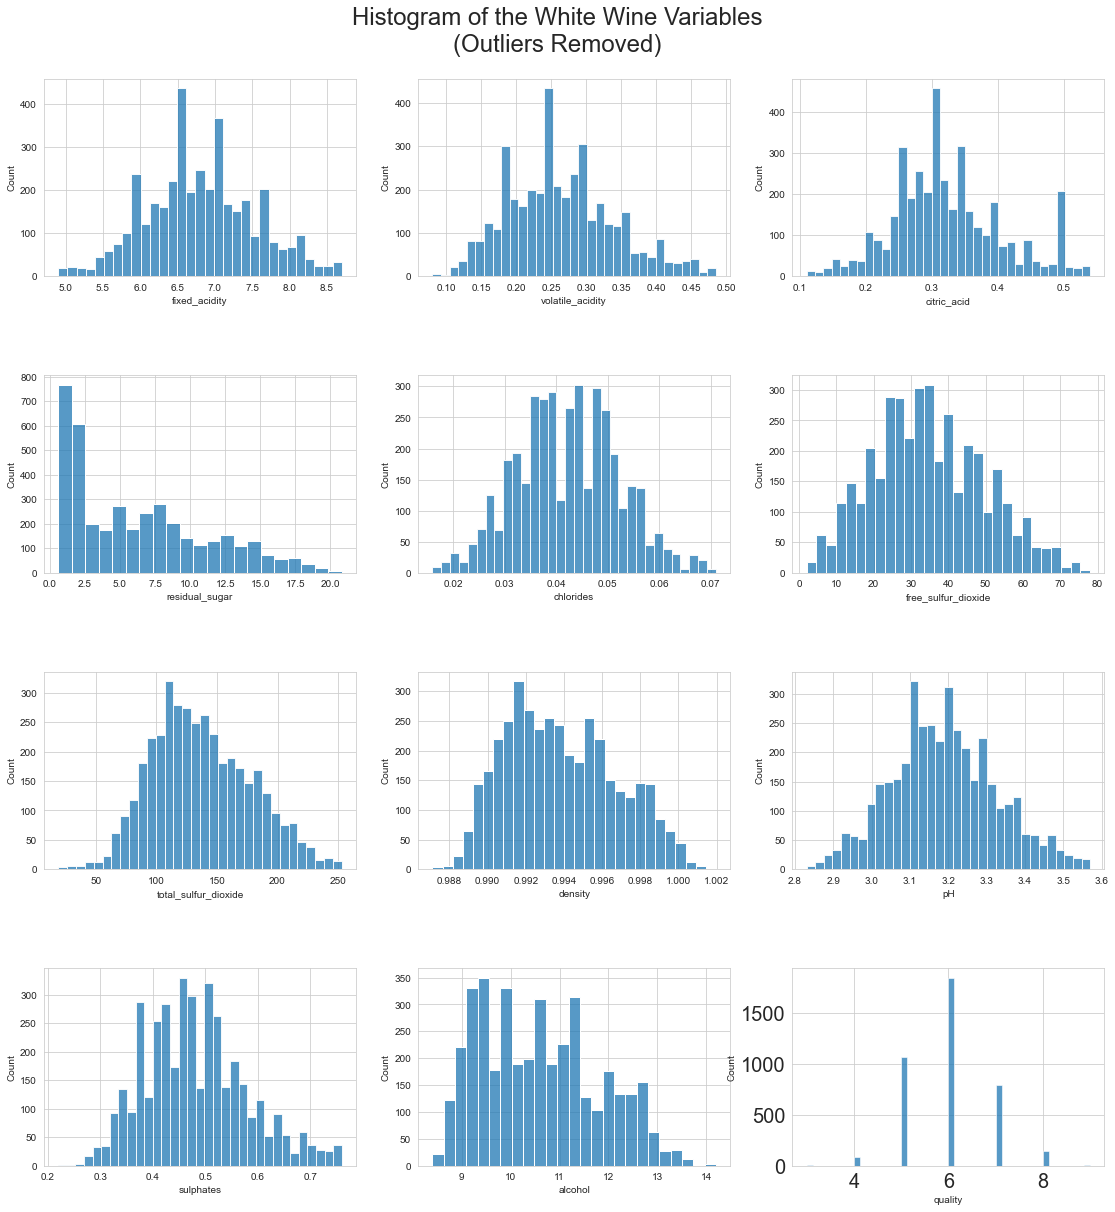

In [6]:
#Historgrams  - outliers removed (df)
def subplot_histplot(data, row = 4, column = 3, title = "Subplots", height = 20, width = 19):
    # Create a figure instance, and the subplots
    fig = plt.figure(figsize = (width, height))
    fig.suptitle(title, fontsize=24, y = 0.93)
    # Run loop over the all the variables
    for i in range(data.shape[1]):
        # Create the axis line
        ax = fig.add_subplot(row, column, i + 1)
        fig.subplots_adjust(hspace = .5)
        # Create histogram for each variable
        plot = sns.histplot(df.iloc[:, i], ax=ax)
    # Show the plot
    plot.tick_params(labelsize = 20)
    plt.show()

plot_columns = ['quality','fixed_acidity','volatile_acidity', 'citric_acid', 'residual_sugar','chlorides','free_sulfur_dioxide','total_sulfur_dioxide','density', 'pH', 'sulphates','alcohol']
    


myhistplot = subplot_histplot(df[plot_columns], row = 4, column = 3, title = "Histogram of the White Wine Variables\n(Outliers Removed)")


### Train-Test-Split

In [7]:
#Independent variables (X) = everything but the target variable, y
#Target variable, y, is quality

#Set X to all the input variables (everything except 'quality')
X = df.drop('quality',axis=1)

#Set the variable to be predicted (y) to 'quality'
y = df['quality']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)


### Scale Independent Variables

In [9]:
# applying Standard Scaling to the dataset to scale all the field values to same scale (approx.).

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)



# RandomForestRegressor

sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

# Instantiate the Random Forest Regressor Model

In [10]:
rfr = RandomForestRegressor(n_estimators = 200, max_depth=20, min_samples_leaf=50, random_state = 42)

# Fit the Model to the Training Data

In [11]:
rfrModel = rfr.fit(X_train,y_train)

# Predict Using Test Data

In [12]:
y_pred = rfrModel.predict(X_test)

In [13]:
print(y_pred)

[6.17101088 5.3351805  6.68419305 6.60430681 6.35355541 5.42235866
 5.33471702 5.79548565 6.54200756 5.36776966 6.83366797 5.68670803
 6.48052481 6.06534927 5.98685769 5.9013008  5.44180907 5.74187769
 5.6368413  5.49168162 5.21876505 6.29995129 6.03028761 6.62896658
 6.17060567 6.70618425 6.11400559 5.83203519 6.63434914 6.4845837
 6.22481404 6.3458852  5.74187769 5.75573228 5.71940934 6.03551791
 5.68373197 5.70973547 6.57216535 4.98405081 6.14855783 5.75646814
 5.19787623 5.78524312 6.74052781 6.43434957 5.83207892 5.7460226
 6.54506656 5.15608822 6.83264347 6.06502439 5.53772642 5.85902108
 6.23796829 5.832331   5.38476485 5.56387898 6.30221343 5.88742738
 5.95839847 5.78733997 5.88780698 5.97745646 5.95821251 5.31022821
 5.92192716 5.55857938 6.82452712 5.85540454 5.73705334 5.92411187
 6.32664681 6.75972772 5.73530755 5.07974903 5.5850663  6.32238335
 5.94827328 5.29200744 6.77429246 5.65944378 6.04747045 5.21052116
 6.2688338  5.4593039  6.15539042 5.95250736 6.54163916 5.760014

In [14]:
print(rfr.predict([[0,0,0,0,0,0,0,0,0,0,0]]))

[5.77152794]


In [15]:
print(rfrModel.predict([[0,0,0,0,0,0,0,0,0,0,0]]))

[5.77152794]


# Evaluate Model

In [16]:
mae_r = mean_absolute_error(y_test,y_pred)
mse_r = mean_squared_error(y_test,y_pred)

In [17]:
print("Mean Absolute Error (MAE):",round(mae_r,4))
print("Mean Squared Error (MSE):",round(mse_r,4))


Mean Absolute Error (MAE): 0.524
Mean Squared Error (MSE): 0.4432


In [18]:
importance = rfrModel.feature_importances_
importance

array([0.0191299 , 0.18099098, 0.00981886, 0.05624667, 0.0314692 ,
       0.09130979, 0.01294707, 0.01419032, 0.04357298, 0.02088839,
       0.51943583])

In [19]:
columns = X.columns

In [20]:
rfrGraph = pd.Series(importance,columns)
rfrGraph

fixed_acidity           0.019130
volatile_acidity        0.180991
citric_acid             0.009819
residual_sugar          0.056247
chlorides               0.031469
free_sulfur_dioxide     0.091310
total_sulfur_dioxide    0.012947
density                 0.014190
pH                      0.043573
sulphates               0.020888
alcohol                 0.519436
dtype: float64

[Text(0.5, 1.0, 'White Wine Quality - Random Forest Regressor Model Visualization (Outliers Removed)')]

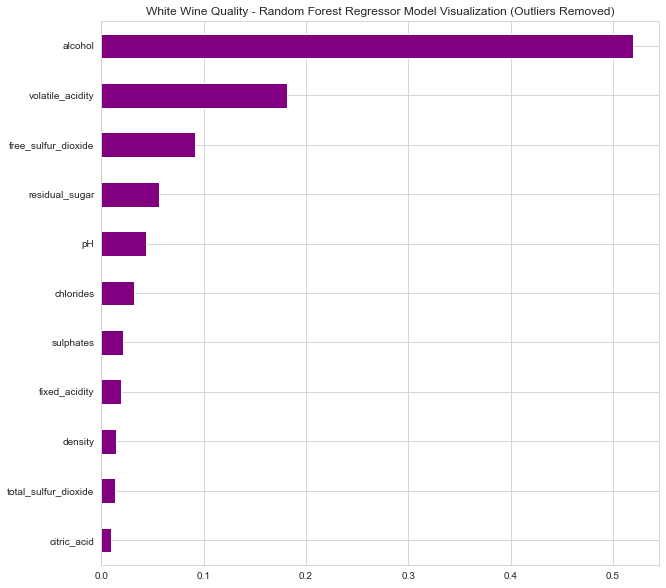

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10,10))

rfrGraph.sort_values().plot.barh(color="purple")

[plt.title("White Wine Quality - Random Forest Regressor Model Visualization (Outliers Removed)")]

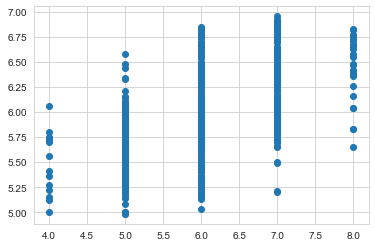

In [23]:
#Plot actual vs. predicted.
plt.scatter(y_test,y_pred)